# Transformers in ``aeon_neuro``

Most EEG analysis begins with some form of transform. These transforms take a single
EEG (a possibly multivariate time series) and return a new series or a collection
of series with different
properties. Transformers for a single EEG all implement the ``aeon`` base class
``BaseSeriesTransformer``. ``BaseSeriesTransformer`` classes follow the scikit learn model of ``fit`` and
``transform``. They take a single EEG stored in a numpy array of shape ``(n_channels,
 n_timepoints)`` and return a transformed series, possibly of a different shape. The
following transformers are available in the ``aeon_neuro`` package:

## Single EEG Transformers


 - [The Band Power Transformer](#BandPowerTransformer)

### ``BandPowerTransformer``



The ``BandPowerTransformer`` transforms each channel of an EEG independently into its
 frequency components using the Fourier transform. The power of these frequency components can be used to
estimate the power within specific frequency bands. Commonly used power bands are
 alpha (8 – 13 Hz), beta (13 – 30 Hz), gamma (30 – 100 Hz), theta (4 – 8 Hz) and
 delta (1 – 4 Hz). The  ``BandPowerSeriesTransformer`` class estimates the
power of an  EEG signal across these five physiological sub-bands using windowed FFTs
. The transform involves segmenting or windowing a single channel, performing a Fourier transform on the window, then summing the power of the frequency components within defined frequency bands. This transformer is useful for extracting features from EEG signals that are relevant for classification tasks, such as sleep stage classification.

This example starts by simulating EEG-like series' with power law noise to
demonstrate the ``BandPowerTransformer``. We simulate
a single channel that transitions every 1000 timepoints from different [noise
colours](https://en.wikipedia.org/wiki/Colors_of_noise), from red to
pink to white to blue to violet noise. Specifically, the power $P(f)$ at frequency $f$ follows the relationship $P(f) \propto \frac{1}{f^\beta}$, with the spectral exponent $\beta$ changing every 1000 timepoints.


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import fftconvolve, welch

n_timepoints, sfreq, window_size = 1000, 256, 128


def sim_powerlaw(sfreq, exponent, n_timepoints=1000, random_seed=0):
    """Simulate Gaussian noise with power law spectrum.
    (https://gist.github.com/nmayorov/e01d7081471d8ef95c4c42c4b8144224)
    """
    rng = np.random.default_rng(seed=random_seed)
    fir_coeffs = np.empty(n_timepoints)
    fir_coeffs[0] = 1
    for idx in range(1, len(fir_coeffs)):
        fir_coeffs[idx] = (0.5 * exponent + idx - 1) / idx * fir_coeffs[idx - 1]

    white_noise = rng.standard_normal(n_timepoints)
    scale = sfreq ** (1 - exponent)

    noise = fftconvolve(fir_coeffs, white_noise, axes=0)[:n_timepoints]

    return (scale * sfreq ** (1 - exponent)) ** 0.5 * noise


# define noise types
noise_colors = ["red", "pink", "white", "blue", "violet"]
noise_exponents = [2, 1, 0, -1, -2]

# generate EEG and labels
EEG = []
for exponent in noise_exponents:
    epoch = sim_powerlaw(sfreq, exponent, n_timepoints=n_timepoints, random_seed=0)
    EEG.append(epoch)

print(len(EEG))
EEG = np.array(EEG)
print(" EEG shape = ", EEG.shape)

5
 EEG shape =  (5, 1000)


It is apparent from plotting the different noise types side-by-side in the time and
frequency domains that they are visually difficult to separate in the time domain, but near perfectly separable in the frequency domain - especially in δ, θ, α, β, and γ EEG sub-bands (dashed vertical lines). The `BandPowerSeriesTransformer` converts a single series into five series representing the power bands of an EEG signal changing over time.  The power is
calculated by summing the squared magnitude of the FFT coefficients within each
frequency band for any given interval. The transformer returns a 2D array with shape `
(5_bands, n_timepoints//window_size)`, where each row represents a frequency band.

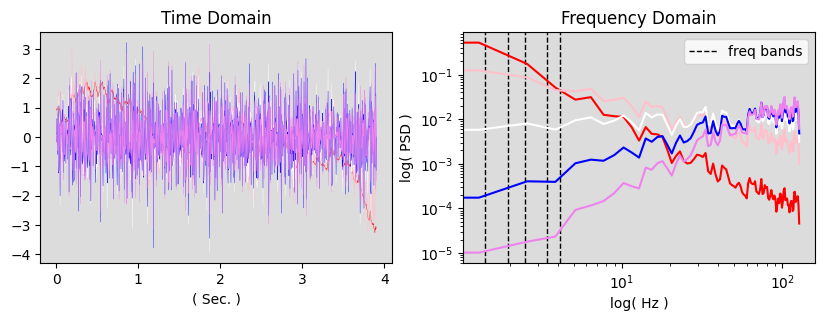

In [45]:
def plot_time_domain(x, sfreq, ax):
    """Plot series."""
    x = (x - x.mean()) / x.std()
    return ax.plot(np.arange(len(x)) / sfreq, x)[0]


def plot_frequency_domain(x, sfreq, ax):
    """Plot power spectral density."""
    freqs, powers = welch(x, sfreq, nperseg=200)
    powers /= np.sum(powers)
    return ax.loglog(freqs, powers)[0]


from aeon_neuro.transformations.series import BandPowerSeriesTransformer

# δ, θ, α, β, and γ frequency bands
freq_bands = BandPowerSeriesTransformer.FREQ_BANDS
vlines = np.log([value[1] for value in freq_bands.values()])

# setup plots
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
[ax.set_facecolor("gainsboro") for ax in axs]
axs[0].set_title("Time Domain")
axs[0].set_xlabel("( Sec. )")
axs[1].set_title("Frequency Domain")
axs[1].set_xlabel("log( Hz )")
axs[1].set_ylabel("log( PSD )")
[axs[1].axvline(x=vline, color="k", ls="--", lw=1) for vline in vlines]
axs[1].legend(["freq bands"])

for idx in range(len(noise_colors)):
    x = EEG[idx]
    plot_time_domain(x, sfreq, axs[0]).set(color=noise_colors[idx], lw=0.3)
    plot_frequency_domain(x, sfreq, axs[1]).set(color=noise_colors[idx])

If we concatenate (And normalise) these simulated single channels, we can use the `BandPowerSeriesTransformer` to extract the power bands of the EEG signal. The transformer will return a 2D array with shape `(5_bands, n_timepoints//window_size)`, where each row represents a frequency band.

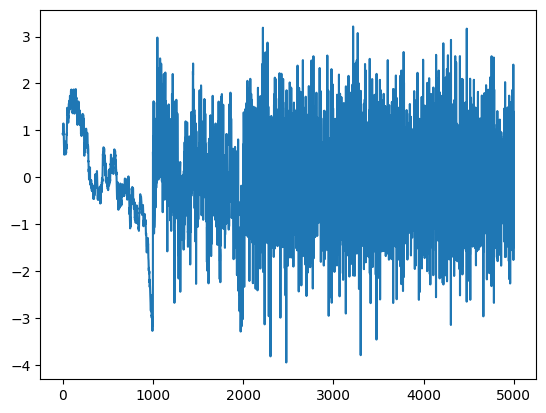

In [46]:
from aeon_neuro.transformations.series import BandPowerSeriesTransformer

single_channel = []
for x in EEG:
    single_channel.append((x - x.mean()) / x.std())
single_channel = np.array(single_channel)
single_channel = single_channel.flatten()
plt.plot(single_channel)

The ``BandPowerTransformer`` takes a single series and transforms each channel using 
a sliding wide. By default, it transforms a `(n_channels, n_timepoints)` EEG into `
(5, n_timepoints-window_length)` series, where each row represents a the 
average of a frequency band over the channels. If we just transform one channel, we 
can see how the power changes over time.

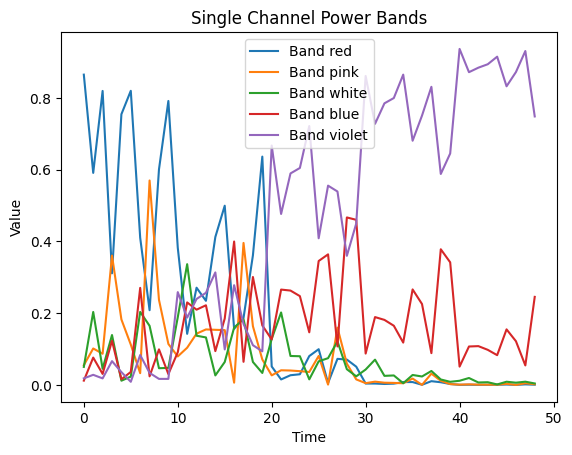

In [50]:
from aeon_neuro.transformations.series import BandPowerSeriesTransformer

bp = BandPowerSeriesTransformer(window_size=window_size, sfreq=sfreq, stride=100)
X2 = bp.fit_transform(single_channel)
# Plot each row
for i in range(X2.shape[0]):
    plt.plot(X2[i], label=f"Band {noise_colors[i]}")

# Add labels, legend, and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Single Channel Power Bands")
plt.legend()
plt.show()